In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

In [2]:
wide_indices_tickers = {
    "中证1000": "000852.SZ",
    "中证全指": "000985.SZ",
    "IBEX 35": "IBEX",
    "MSCI ACWI": "ACWI",
    "FTSE MIB": "FTSEMIB.MI",
    "MOEX Russia Index": "IMOEX.ME",
    "SGX FTSE Straits Times Index": "STI",
    "SPDR S&P 500 ETF Trust": "SPY",
    "Invesco QQQ Trust": "QQQ",
    "SPDR Dow Jones Industrial Average ETF Trust": "DIA"
}

In [3]:
# 选择需要的指数
tickers = wide_indices_tickers.values()

# 下载过去两年的日线数据
end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=730)
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
df_result = []
# 计算MACD
def compute_macd(close, short_window=12, long_window=26, signal_window=9):
    short_ema = close.ewm(span=short_window, adjust=False).mean()
    long_ema = close.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    hist = macd - signal
    return macd, signal, hist
for ticker in tickers:
    df = data[ticker]
    df['MACD'], df['MACDSignal'], df['MACDHist'] = compute_macd(df['Close'])
    df.columns = [
    f"{col[0]}_{col[1]}" if col[1] != '' else col[0]
    for col in df.columns.values
    ]
    df['Close'] = df[f'Close_{ticker}']
    df_result.append(df)

In [5]:
# 遍历每一日的数据，并根据不同指数的macd、signal和hist的值来判断买入、卖出和持有
def get_signal(row):
    if row['MACD'] > row['MACDSignal'] and row['MACDHist'] > 0:
        return 1
    elif row['MACD'] < row['MACDSignal'] and row['MACDHist'] < 0:
        return -1
    else:
        return 0
for df in df_result:
    df['Signal'] = df.apply(get_signal, axis=1)

In [6]:
# 提取交易信号，并合并到一个DataFrame中，列名是指数的名称
for df in df_result:
    df['Signal'] = df['Signal'].shift(1)
signals = pd.concat([df['Signal'] for df in df_result], axis=1)
signals.columns = wide_indices_tickers.keys()

In [7]:
signals = signals.T.fillna(0)

In [8]:
# 收益率序列
pct_df = pd.concat([df['Close'].pct_change() for df in df_result], axis=1)
pct_df.columns = wide_indices_tickers.keys()
pct_df = pct_df.T
# 手续费
fee_df = abs(signals.diff(axis=1).fillna(0))*1e-4
pnl_series = ((pct_df.shift(-1,axis=1).fillna(0)*signals-fee_df).mean()+1).cumprod()

<Axes: xlabel='Date'>

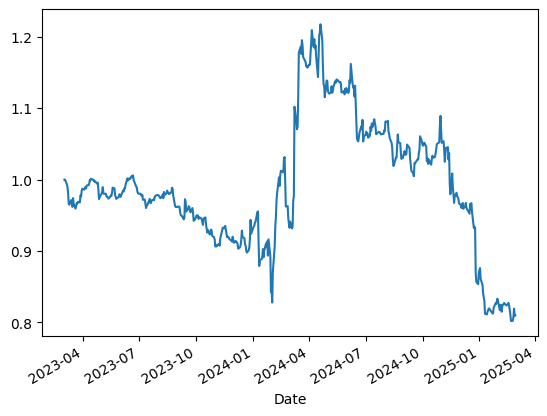

In [9]:
pnl_series.plot()

In [10]:
def weight_signals_by_return_ranking(signals: pd.DataFrame, returns: pd.DataFrame) -> pd.DataFrame:
    """
    根据前一日的涨幅排名，为当天的交易信号赋予递减权重。

    权重规则：
      假设指数总数为 N，
      对于前一日涨幅排序，排名第1的指数权重为 N，
      第2的指数权重为 N-1，
      …，
      第 N 的指数权重为 1。
    最后将权重归一化，使得所有权重之和为1，再将当天的原始信号乘以对应权重。

    参数:
        signals: DataFrame，每日各指数的原始交易信号，行索引为日期，列为指数代码。
        returns: DataFrame，每日各指数的涨幅数据，行索引为日期，列为指数代码。

    返回:
        weighted_signals: DataFrame，加权后的交易信号。
    """
    # 保证两个 DataFrame 的日期顺序正确
    signals = signals.sort_index()
    returns = returns.sort_index()

    weighted_signals = signals.copy()
    n_indices = len(signals.columns)

    # 计算权重的分母，即所有递减权重的和：N + (N-1) + ... + 1
    total_weight = np.sum(np.arange(n_indices, 0, -1))

    # 从第二天开始处理（第一天没有前一日数据，可选择置0或保留原信号）
    for i in range(1, len(signals)):
        current_date = signals.index[i]
        prev_date = signals.index[i-1]
        # 获取前一日的涨幅数据
        prev_returns = returns.loc[prev_date]
        # 按涨幅从高到低排序，得到指数的顺序列表
        sorted_indices = prev_returns.sort_values(ascending=False).index.tolist()

        # 构造权重字典：排名第1的权重为 N/total_weight，排名第2的为 (N-1)/total_weight，...
        weight_map = { idx: (n_indices - rank + 1) / total_weight
                       for rank, idx in enumerate(sorted_indices, start=1) }

        # 对当天的每个指数信号乘以对应的权重
        for idx in signals.columns:
            weighted_signals.at[current_date, idx] = signals.at[current_date, idx] * weight_map[idx]

    # 对于第一天没有前一日数据，可统一置为0（或按需要处理）
    weighted_signals.iloc[0] = 0
    return weighted_signals

In [17]:
weighted_signals = weight_signals_by_return_ranking(signals.T, pct_df.T)
weighted_signals = weighted_signals.T

In [18]:
fee_df = abs(weighted_signals.diff(axis=1).fillna(0))*1e-4
pnl_series_weighted = ((pct_df.shift(-1,axis=1).fillna(0)*weighted_signals-fee_df).mean()+1).cumprod()

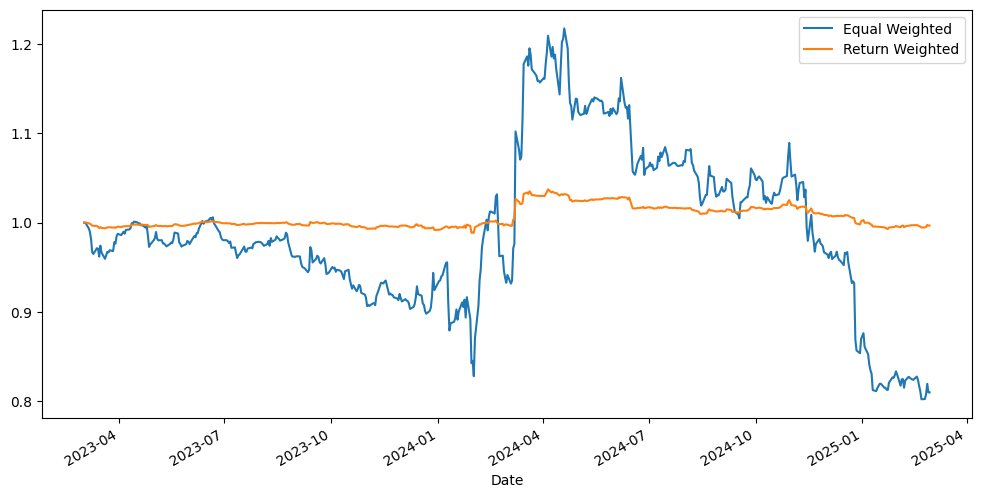

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
pnl_series.plot(label="Equal Weighted")
pnl_series_weighted.plot(label="Return Weighted")
plt.legend()
plt.show()